# **Inteligencia Artificial y Aprendizaje Automático**
## **Maestría en Inteligencia Artificial Aplicada**

**Dr Luis Eduardo Falcón Morales**

**Tecnológico de Monterrey**
### **Actividad Individual: Pronósticos con Series de Tiempo**


#### **Nombre:** Gustavo Aispuro Farias
#### **Matrícula:** A01740067

Modelos para predicción de un problema de serie de tiempo:

* **1. Modelo ingenuo**
* **2. Modelo ARIMA**
* **3. Modelo Prophet**
* **4. Modelo LSTM**

In [2]:
!pip install prophet --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Using cached prophet-1.2.1-py3-none-win_amd64.whl.metadata (3.6 kB)
Using cached prophet-1.2.1-py3-none-win_amd64.whl (12.1 MB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\gusai\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\prophet\\stan_model\\cmdstan-2.37.0\\stan\\lib\\stan_math\\lib\\tbb_2020.3\\include\\tbb\\internal\\_deprecated_header_message_guard.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\gusai\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# **1 - Modelo ingenuo**

RMSE (naive estacional): 723.42


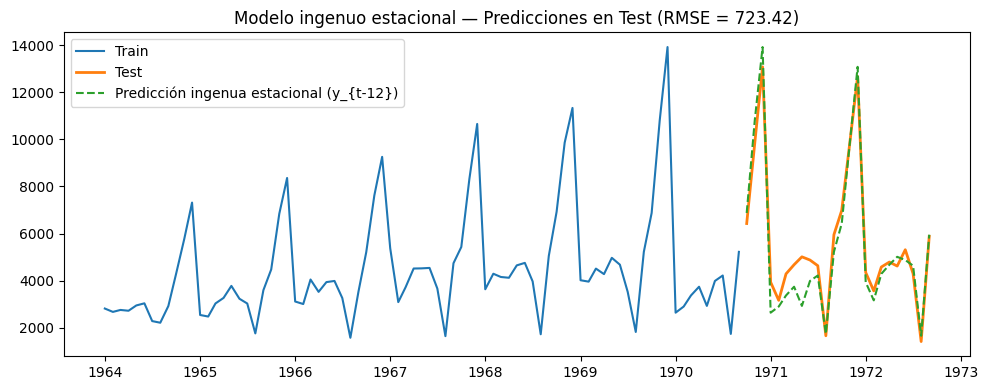

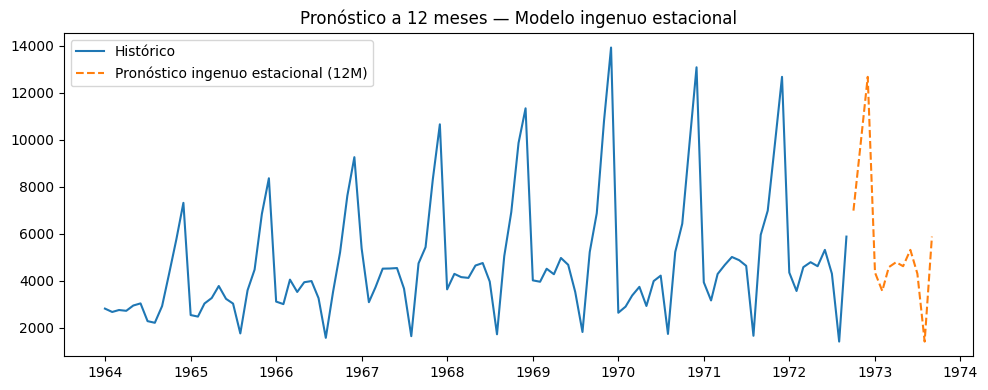

In [3]:
## ++++++++++ Incluye todas las celdas y líneas de código que requieras +++++++++++++++++++++++++
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


df = pd.read_csv("monthly_champagne_sales.csv", parse_dates=["Month"]).sort_values("Month")
df = df.set_index("Month"); df.index.freq = "MS"


h = 24
train, test = df.iloc[:-h].copy(), df.iloc[-h:].copy()


yhat_test = df["Sales"].shift(12).loc[test.index]
rmse = np.sqrt(mean_squared_error(test["Sales"], yhat_test))
print(f"RMSE (naive estacional): {rmse:,.2f}")


plt.figure(figsize=(10,4))
plt.plot(train.index, train["Sales"], label="Train")
plt.plot(test.index, test["Sales"], label="Test", linewidth=2)
plt.plot(test.index, yhat_test, label="Predicción ingenua estacional (y_{t-12})", linestyle="--")
plt.title(f"Modelo ingenuo estacional — Predicciones en Test (RMSE = {rmse:,.2f})")
plt.legend(); plt.tight_layout(); plt.show()


naive_pred_test = pd.DataFrame({"y_true": test["Sales"], "yhat_naive_seasonal": yhat_test})
naive_pred_test.head()


last_date = df.index[-1]
future_index = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=12, freq="MS")
future_forecast = pd.Series(df["Sales"].iloc[-12:].values, index=future_index, name="forecast")

plt.figure(figsize=(10,4))
plt.plot(df.index, df["Sales"], label="Histórico")
plt.plot(future_forecast.index, future_forecast.values, label="Pronóstico ingenuo estacional (12M)", linestyle="--")
plt.title("Pronóstico a 12 meses — Modelo ingenuo estacional")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
####Con RMSE = 723.42, el modelo 𝑦𝑡−12 rinde muy bien porque la serie tiene estacionalidad anual fuerte. Es simple, robusto y difícil de superar sin variables externas; limita si cambian tendencias o hay choques fuera del patrón histórico.

# **2 - Modelo ARIMA**

RMSE SARIMA(1,1,1)x(1,1,1,12): 910.15


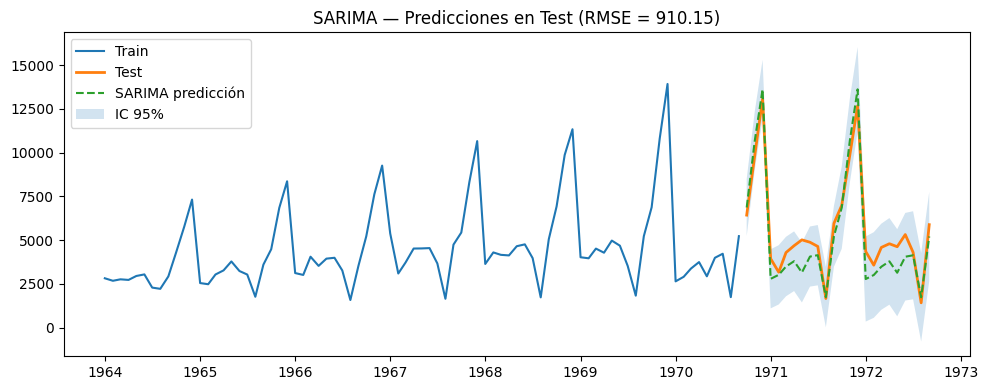

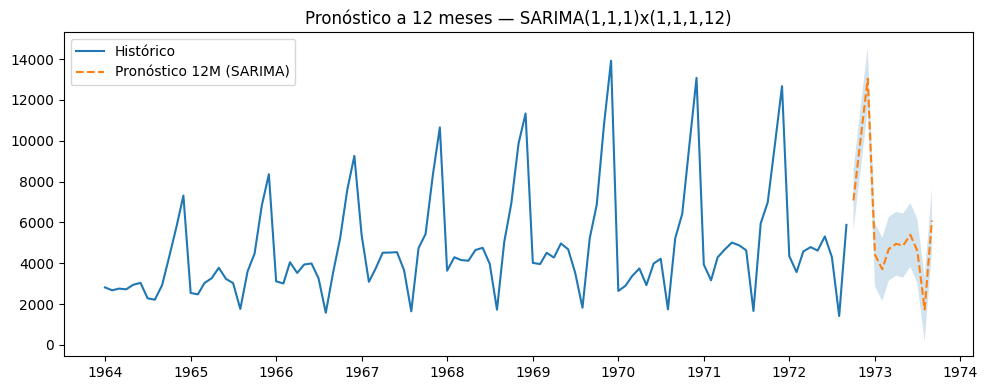

,y_true,yhat_sarima
1970-10-01,6424,6859.081693
1970-11-01,9842,10673.367013
1970-12-01,13076,13609.231302
1971-01-01,3934,2782.941550
1971-02-01,3162,3011.733838


In [4]:
## ++++++++++ Incluye todas las celdas y líneas de código que requieras +++++++++++++++++++++++++

import warnings
warnings.filterwarnings("ignore")

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

df = pd.read_csv("monthly_champagne_sales.csv", parse_dates=["Month"]).sort_values("Month")
df = df.set_index("Month"); df.index.freq = "MS"
h = 24
train, test = df.iloc[:-h].copy(), df.iloc[-h:].copy()

sarima = SARIMAX(train["Sales"],
                 order=(1,1,1),
                 seasonal_order=(1,1,1,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit(disp=False)

pred_test = sarima.get_forecast(steps=h)
yhat = pred_test.predicted_mean
rmse_sarima = np.sqrt(mean_squared_error(test["Sales"], yhat))
print(f"RMSE SARIMA(1,1,1)x(1,1,1,12): {rmse_sarima:,.2f}")

ci = pred_test.conf_int()
lower, upper = ci.iloc[:,0].astype(float).values, ci.iloc[:,1].astype(float).values

plt.figure(figsize=(10,4))
plt.plot(train.index, train["Sales"], label="Train")
plt.plot(test.index,  test["Sales"],  label="Test", linewidth=2)
plt.plot(test.index,  yhat.values,   label="SARIMA predicción", linestyle="--")
plt.fill_between(test.index, lower, upper, alpha=0.2, label="IC 95%")
plt.title(f"SARIMA — Predicciones en Test (RMSE = {rmse_sarima:,.2f})")
plt.legend(); plt.tight_layout(); plt.show()

sarima_full = SARIMAX(df["Sales"], order=(1,1,1), seasonal_order=(1,1,1,12),
                      enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
future = sarima_full.get_forecast(steps=12)
future_mean = future.predicted_mean
future_ci   = future.conf_int()

plt.figure(figsize=(10,4))
plt.plot(df.index, df["Sales"], label="Histórico")
plt.plot(future_mean.index, future_mean.values, label="Pronóstico 12M (SARIMA)", linestyle="--")
plt.fill_between(future_ci.index, future_ci.iloc[:,0].values, future_ci.iloc[:,1].values, alpha=0.2)
plt.title("Pronóstico a 12 meses — SARIMA(1,1,1)x(1,1,1,12)")
plt.legend(); plt.tight_layout(); plt.show()

sarima_results = pd.DataFrame({
    "y_true": test["Sales"],
    "yhat_sarima": yhat
})
sarima_results.head()


In [ ]:
#####Con RMSE = 910.15, el SARIMA(1,1,1)×(1,1,1)_12 no supera al ingenuo estacional. Captura la estacionalidad pero suaviza los picos y se queda corto en meses extremos. Podría mejorar con ajuste fino o transformaciones, pero en esta serie el baseline sigue siendo mejor.

# **3 - Modelo Prophet**

22:06:35 - cmdstanpy - INFO - Chain [1] start processing
22:06:36 - cmdstanpy - INFO - Chain [1] done processing


RMSE Prophet: 758.80


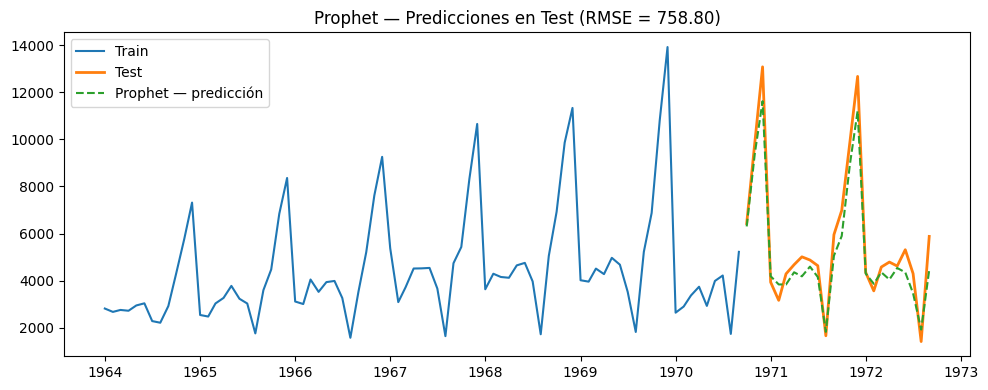

22:06:36 - cmdstanpy - INFO - Chain [1] start processing
22:06:36 - cmdstanpy - INFO - Chain [1] done processing


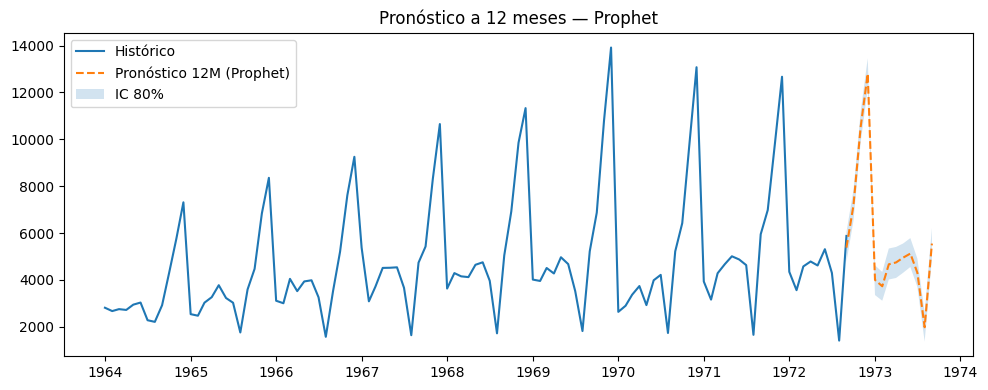

,y_true,yhat_prophet
Month,,
1970-10-01,6424,6301.471528
1970-11-01,9842,9379.198566
1970-12-01,13076,11618.409321
1971-01-01,3934,4187.241118
1971-02-01,3162,3837.752665


In [9]:
## ++++++++++ Incluye todas las celdas y líneas de código que requieras +++++++++++++++++++++++++

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


df = pd.read_csv("monthly_champagne_sales.csv", parse_dates=["Month"]).sort_values("Month")
df = df.set_index("Month"); df.index.freq = "MS"


h = 24
train, test = df.iloc[:-h].copy(), df.iloc[-h:].copy()

try:
    from prophet import Prophet
except Exception:
    from fbprophet import Prophet

train_p = train.reset_index().rename(columns={"Month": "ds", "Sales": "y"})


m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.2 
)
m.fit(train_p)


future_test = m.make_future_dataframe(periods=h, freq="MS")
forecast = m.predict(future_test)

yhat_test = forecast.set_index("ds").loc[test.index, "yhat"]
rmse_prophet = np.sqrt(mean_squared_error(test["Sales"], yhat_test))
print(f"RMSE Prophet: {rmse_prophet:,.2f}")

plt.figure(figsize=(10,4))
plt.plot(train.index, train["Sales"], label="Train")
plt.plot(test.index,  test["Sales"],  label="Test", linewidth=2)
plt.plot(test.index,  yhat_test.values, label="Prophet — predicción", linestyle="--")
plt.title(f"Prophet — Predicciones en Test (RMSE = {rmse_prophet:,.2f})")
plt.legend(); plt.tight_layout(); plt.show()

full_p = df.reset_index().rename(columns={"Month":"ds","Sales":"y"})
m_full = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.2
)
m_full.fit(full_p)
future_12 = m_full.make_future_dataframe(periods=12, freq="MS")
forecast_12 = m_full.predict(future_12)

hist = df.copy()
fc_tail = forecast_12.set_index("ds").loc[hist.index[-1]:]
plt.figure(figsize=(10,4))
plt.plot(hist.index, hist["Sales"], label="Histórico")
plt.plot(fc_tail.index, fc_tail["yhat"], label="Pronóstico 12M (Prophet)", linestyle="--")
plt.fill_between(fc_tail.index, fc_tail["yhat_lower"], fc_tail["yhat_upper"], alpha=0.2, label="IC 80%")
plt.title("Pronóstico a 12 meses — Prophet")
plt.legend(); plt.tight_layout(); plt.show()

prophet_results = pd.DataFrame({
    "y_true": test["Sales"],
    "yhat_prophet": yhat_test
})
prophet_results.head()


In [ ]:
####Con RMSE = 758.80, Prophet queda cerca del ingenuo estacional pero no lo supera. Captura bien la estacionalidad anual, aunque suaviza picos. La ventaja es que da bandas de incertidumbre y permite agregar festivos, con navidad o año Nuevo podría mejorar.

# **4 - Modelo LSTM**

#### **NOTA: En general, recordemos que los modelos basados en redes neuronales son afectados de manera importante cuando la escala de los datos se va incrementando. Por ello, en este caso podría ser conveniente escalar los datos de nuestra variable temporal, por ejemplo entre 0 y 1. Tomarlo en cuenta para que al final puedes realizar las predicciones en las unidades originales.**

RMSE LSTM (PyTorch): 2,561.16


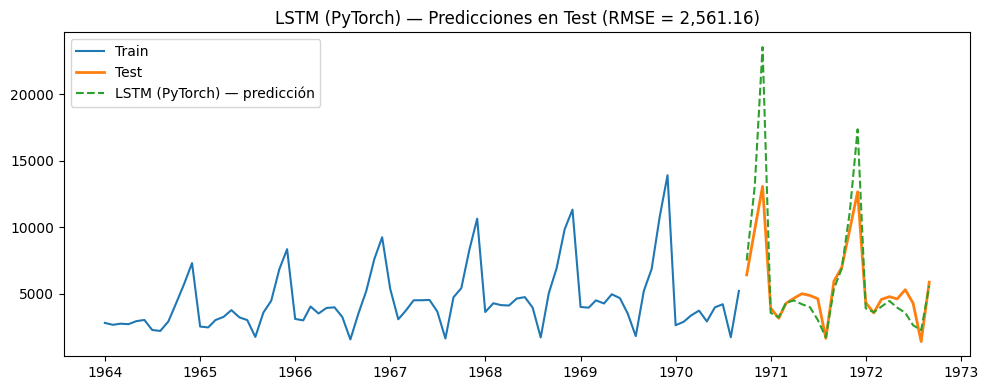

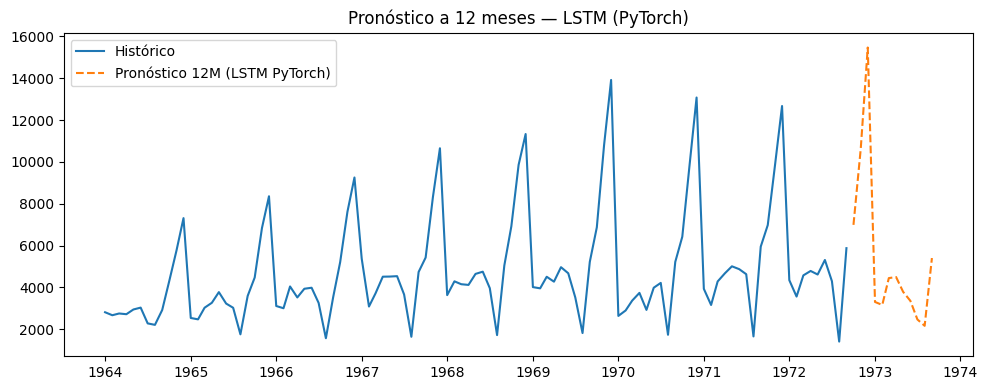

,y_true,yhat_lstm
Month,,
1970-10-01,6424,7507.137207
1970-11-01,9842,13100.014648
1970-12-01,13076,23552.746094
1971-01-01,3934,3574.522217
1971-02-01,3162,3234.860352


In [ ]:
## ++++++++++ Incluye todas las celdas y líneas de código que requieras +++++++++++++++++++++++++
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

torch.manual_seed(42)
device = torch.device("cpu")

df = pd.read_csv("monthly_champagne_sales.csv", parse_dates=["Month"]).sort_values("Month")
df = df.set_index("Month"); df.index.freq = "MS"
h, lookback = 24, 12          
train, test = df.iloc[:-h].copy(), df.iloc[-h:].copy()

scaler = MinMaxScaler((0,1))
train_s = scaler.fit_transform(train[["Sales"]]).ravel()
test_s  = scaler.transform(test[["Sales"]]).ravel()


def make_Xy(arr, win):
    X, y = [], []
    for i in range(win, len(arr)):
        X.append(arr[i-win:i])
        y.append(arr[i])
    X = torch.tensor(np.array(X), dtype=torch.float32).unsqueeze(-1)  
    y = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(-1)  
    return X, y

Xtr, ytr = make_Xy(train_s, lookback)
test_input = np.concatenate([train_s[-lookback:], test_s])
Xte, yte   = make_Xy(test_input, lookback)

class LSTMNet(torch.nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size=1, hidden_size=hidden, batch_first=True)
        self.fc   = torch.nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMNet(64).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = torch.nn.MSELoss()
epochs = 400
for epoch in range(epochs):
    model.train(); opt.zero_grad()
    pred = model(Xtr)
    loss = crit(pred, ytr)
    loss.backward(); opt.step()

model.eval()
with torch.no_grad():
    yhat_s = model(Xte).cpu().numpy().ravel()

yhat = scaler.inverse_transform(yhat_s.reshape(-1,1)).ravel()
y_true = test["Sales"].values
rmse_lstm = float(np.sqrt(mean_squared_error(y_true, yhat)))
print(f"RMSE LSTM (PyTorch): {rmse_lstm:,.2f}")


plt.figure(figsize=(10,4))
plt.plot(train.index, train["Sales"], label="Train")
plt.plot(test.index,  test["Sales"],  label="Test", linewidth=2)
plt.plot(test.index,  yhat,          label="LSTM (PyTorch) — predicción", linestyle="--")
plt.title(f"LSTM (PyTorch) — Predicciones en Test (RMSE = {rmse_lstm:,.2f})")
plt.legend(); plt.tight_layout(); plt.show()


full_s = scaler.fit_transform(df[["Sales"]]).ravel()
window = full_s[-lookback:].tolist()
future_steps = 12; fut_preds = []
for _ in range(future_steps):
    x = torch.tensor(np.array(window[-lookback:]), dtype=torch.float32).view(1, lookback, 1)
    with torch.no_grad():
        yhat_step = model(x).item()
    fut_preds.append(yhat_step); window.append(yhat_step)

future_forecast = scaler.inverse_transform(np.array(fut_preds).reshape(-1,1)).ravel()
future_index = pd.date_range(df.index[-1] + pd.offsets.MonthBegin(1), periods=future_steps, freq="MS")

plt.figure(figsize=(10,4))
plt.plot(df.index, df["Sales"], label="Histórico")
plt.plot(future_index, future_forecast, label="Pronóstico 12M (LSTM PyTorch)", linestyle="--")
plt.title("Pronóstico a 12 meses — LSTM (PyTorch)")
plt.legend(); plt.tight_layout(); plt.show()


lstm_results = pd.DataFrame({"y_true": y_true, "yhat_lstm": yhat}, index=test.index)
lstm_results.head()


In [ ]:
####Con RMSE = 2,561.16, el LSTM rinde peor que los demás. Con pocos datos univariados la red no generaliza y tiende a sobreajustar. Solo tendría sentido con más historia, regresores exógenos o un tuning más profundo, para esta serie, no es la opción adecuada.

In [ ]:
#### **Conclusiones de la actividad:** El mejor desempeño lo da el ingenuo estacional. Ese resultado confirma que la demanda de champaña está dominada por un patrón anual repetitivo y relativamente estable. Pero vale la pena tambien mencionar que Prophet queda muy cerca del baseline y es útil si necesitas intervalos de confianza y una forma rápida de incorporar festivos/regresores.
#### Por eso, creo que se puede utilizar el ingenuo como referencia operativa si se busca algo simple y estable. Por otro lado, si se necesita explicabilidad y posibilidad de agendar efectos de calendario, o promociones como regresores, se puede empatar o superar el baseline.

## **<<< Fin de la Actividad de la Semana - Pronósticos y Series de Tiempo >>>**